## Load IDR-0080 Data & Cell Health Data
# Reference : https://pubmed.ncbi.nlm.nih.gov/33534641/

In [994]:
import pandas as pd
import numpy as np
x_df = pd.read_csv('cell_painting_modz.tsv', sep = '\t')
x_meta = x_df.iloc[:, :3]
x_df = x_df.iloc[:, 3:]

y_all_df = pd.read_csv('cell_health_modz.tsv', sep = '\t')
y_df = y_all_df['vb_ros_mean']

## ROS mean value check for categorization

In [995]:
print(y_df.sort_values(ascending = False))

list = [178, 177, 302, 248, 341]
for k in list:
    print(x_meta['Metadata_pert_name'][x_meta.index == k])

178    8.832083
177    8.087058
302    2.355112
248    2.255322
341    1.562436
         ...   
305   -0.984692
346   -0.990672
314   -0.998404
240   -1.167189
286   -1.240591
Name: vb_ros_mean, Length: 357, dtype: float64
178    GPX4-2
Name: Metadata_pert_name, dtype: object
177    GPX4-1
Name: Metadata_pert_name, dtype: object
302    JAK3-1
Name: Metadata_pert_name, dtype: object
248    BCL2-2
Name: Metadata_pert_name, dtype: object
341    SDHB-1
Name: Metadata_pert_name, dtype: object


## Divied 3 clusters for ROS mean by k-means clustering

In [996]:
from sklearn.cluster import KMeans

#std = y_df.std()
#q60 = y_df.quantile(0.60)
#med = y_df.median()


#def labeling(value):
    #if value >= std * 1.5:
        #return 1
    #else:
        #return 0


#y_df_binarized = y_df.apply(labeling)

# kmean
kmeans = KMeans(n_clusters=3, random_state=42)
y_clusters = kmeans.fit_predict(y_df.values.reshape(-1, 1))

y_df_binarized = y_clusters

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [997]:
#np.where(y_df_binarized == 0)

(array([  0,   1,  10,  12,  15,  29,  30,  32,  33,  35,  36,  48,  50,
         60,  61,  62,  63,  64,  66,  67,  69,  72,  75,  78,  88,  89,
         96, 103, 107, 129, 151, 180, 183, 185, 186, 197, 222, 248, 270,
        273, 287, 289, 296, 297, 299, 302, 310, 321, 327, 328, 329, 341],
       dtype=int64),)

In [998]:
from collections import Counter

Counter(y_df_binarized)

Counter({1: 303, 0: 52, 2: 2})

# Cluster 0, 2 are considered to be ROS induced perterbation group
# Cluster 1 is considered to be ROS reducer perterbation group

In [968]:
# Remapping
mapping = {1: 1, 0: 0, 2: 0}
y_df_binarized = np.vectorize(mapping.get)(y_df_binarized)

In [969]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load validation data cpg0012
# Data processing by pycytominer
# 1. Normalization (mad_roubstize) ref : https://github.com/broadinstitute/cell-health/tree/master/1.generate-profiles
# 2. MODZ scaling ref : https://github.com/broadinstitute/cell-health/tree/master/1.generate-profiles

In [982]:
import pycytominer



x_val_dat = pd.read_csv('mean_well_profiles.csv')

x_val_norm_dat = pycytominer.normalize(
    profiles = x_val_dat,
    method = 'mad_robustize',
    samples = "Metadata_broad_sample == 'DMSO'"
)

x_val_norm_dat = x_val_norm_dat.query('Metadata_broad_sample != "DMSO"')

x_val_meta = x_val_norm_dat.iloc[:, :17]
x_val_df = x_val_norm_dat.iloc[:, 17:]

In [983]:
# MODZ scaling for validation dataset
from scipy.stats import median_abs_deviation
from pycytominer.consensus import modz


x_val_df['Metadata_broad_sample'] = x_val_meta['Metadata_broad_sample']

x_df_modz = modz(
    x_val_df,
    replicate_columns = ['Metadata_broad_sample'],
    precision = 5
)

x_df_modz = x_df_modz.iloc[:, 1:]
x_df_modz

,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,2.983067,0.033725,1.810475,4.845367,4.597296,0.0,-4.457198,-0.756633,4.781518,4.758277,...,0.527916,-0.945680,-1.499915,-1.475458,0.059823,-0.362329,-0.556439,-0.963316,-1.429889,-1.017730
1,3.748447,-1.416431,0.070999,1.077092,2.044613,0.0,0.470251,-0.868390,4.130878,3.867700,...,5.729674,-0.628977,0.708489,0.047374,1.295114,1.816189,1.687444,2.263363,1.118357,1.420036
2,1.829257,-0.944287,-2.591464,0.067278,1.038194,0.0,0.417983,1.031205,2.126213,1.893961,...,5.573728,-0.453700,0.233767,-0.396174,0.172084,1.538639,1.382851,1.344175,1.269507,1.339843
3,3.178239,-1.214083,0.141998,4.452962,3.766659,0.0,-2.212915,0.255671,4.626513,4.361541,...,-0.014593,-0.644673,-0.502878,-0.769201,-0.842631,-0.880791,-0.928717,1.121791,0.671824,0.869394
4,1.718277,-0.337245,-0.958487,2.619222,2.550356,0.0,-2.190358,-0.511441,3.006494,2.981861,...,0.393320,0.239472,0.461409,0.303116,-1.621369,-1.988200,-2.476369,0.272011,-0.176855,0.232295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.805562,-0.505868,-0.248497,1.695279,2.314168,0.0,-1.406764,2.417110,1.773564,1.283673,...,0.420578,0.812925,1.291238,1.068771,-3.835764,-5.235588,-5.192188,0.997455,0.896847,1.018380
316,1.096406,2.023472,-0.922987,2.049807,3.142117,0.0,-1.288617,-0.711465,1.958819,1.701170,...,-0.858038,-0.793989,-1.034702,-0.927171,-1.790475,-0.855519,-1.411089,0.809363,-0.147126,0.463491
317,0.535766,1.686227,-0.425994,2.608934,2.901462,0.0,-2.143508,-0.929132,1.296250,1.217076,...,-0.675176,-0.521148,-0.775144,-0.817564,-1.180837,-1.142540,-1.650002,-0.185480,-0.318375,-0.063231
318,1.151896,-1.045461,1.277982,1.886906,1.177775,0.0,-1.706725,-0.260488,1.490439,1.205730,...,-1.413652,-0.035640,-0.362204,-0.335848,-1.732186,-1.475234,-1.649252,-0.342447,-0.046902,0.102344


In [984]:
# Check unique compound in validation dataset
compound = x_val_meta['Metadata_broad_sample'].unique()
len(compound)

320

In [985]:
# Filter except same features in idr0080 & cpg0012
x_cols = x_df.columns
x_val_cols = x_df_modz.columns

filt_cols = x_cols.intersection(x_val_cols)

x_df = x_df[filt_cols]
x_val_df = x_df_modz[filt_cols]


display(x_df)
display(x_val_df)

,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,-0.180160,-0.155631,0.014646,0.188053,1.231056,0.031064,-0.585477,0.467976,0.254203,0.129446,...,0.882859,0.841687,0.339831,0.562585,0.879950,0.904785,0.923143,0.944998,0.984938,0.961945
1,0.370572,-0.247842,-0.030773,0.433778,0.062456,0.266860,0.838679,-0.467417,0.340793,-0.024450,...,0.513820,0.344554,0.134318,0.018933,0.359496,0.557998,0.504751,0.407462,0.522251,0.519441
2,-0.360905,0.794740,0.743296,-0.438752,0.827288,-0.728499,-0.422394,-0.147624,0.083870,-0.160722,...,-0.456539,0.373750,-0.111184,-0.042733,-0.840771,-0.536215,-0.497296,-0.748232,-0.515240,-0.526734
3,0.262450,0.480421,0.821096,-0.337898,0.054479,-0.662314,0.067979,0.025010,0.158138,-0.342062,...,0.115466,0.186411,0.249292,0.688435,-0.521766,0.124801,0.063444,-0.560178,-0.062851,0.026056
4,-0.110264,-0.074895,0.569377,0.571678,0.976504,-1.111947,1.348542,0.584906,-3.128483,-2.324773,...,0.154802,2.975785,1.128414,-0.638839,0.753884,0.808944,0.594059,0.674015,0.140325,0.417465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.446930,0.247953,0.331462,-0.228694,0.648857,-0.394799,-0.477804,-0.203016,0.387554,0.485502,...,0.305814,0.952718,0.697652,0.087784,0.266722,0.254346,0.367875,0.191115,0.220894,0.257950
353,-0.500081,1.455427,1.153796,-1.395398,1.167778,-1.413069,-0.684198,-0.923160,-0.145706,-0.535382,...,-0.207834,-0.280317,-0.422648,-0.763835,-0.254697,-0.380000,-0.404530,-0.266026,-0.341998,-0.287431
354,0.407771,0.719510,0.691270,-0.999921,0.701489,-0.965601,-0.937154,-0.218680,0.145943,-0.149745,...,0.011171,-0.575574,-0.272102,-0.101586,-0.117305,-0.083261,-0.085342,-0.213054,-0.126822,-0.101668
355,0.063720,-0.255658,0.075113,0.999995,0.251456,0.237111,0.342004,0.084765,0.957639,-0.562746,...,0.766721,0.518347,1.450779,1.421830,1.483743,0.639279,0.614153,1.624128,0.523767,0.603819


,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,1.810475,4.845367,4.597296,-4.457198,-0.919055,-4.752526,-1.620377,-4.228027,0.545987,-2.397807,...,0.199091,0.255544,-0.519652,-1.067513,-2.632790,0.092958,0.396231,-2.171522,0.760782,0.527916
1,0.070999,1.077092,2.044613,0.470251,-1.573215,-1.148813,0.222460,-0.724492,2.441020,-1.129402,...,6.269547,3.741846,2.235913,3.003622,0.801665,6.290859,7.760454,-0.607137,6.095655,5.729674
2,-2.591464,0.067278,1.038194,0.417983,-3.268690,-0.559272,0.951902,-0.043207,-0.163714,0.385063,...,6.589674,4.157343,2.116262,2.605032,1.719696,5.401623,7.444836,0.331726,5.919896,5.573728
3,0.141998,4.452962,3.766659,-2.212915,-1.037549,-3.691242,-1.281065,-4.871623,-0.028981,-0.857385,...,-0.307834,-0.270347,-0.175018,0.297472,-1.851784,0.083029,0.069647,-2.607974,0.150893,-0.014593
4,-0.958487,2.619222,2.550356,-2.190358,0.959896,-2.642177,-1.378156,-2.607931,1.251967,0.085436,...,-0.492690,0.289149,-0.993158,-1.374417,-2.129894,-0.138664,0.246014,-2.245849,0.673906,0.393320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.248497,1.695279,2.314168,-1.406764,0.487680,-2.024234,-0.929180,-3.312009,-1.028602,-1.266368,...,-0.650941,-2.326606,-7.551001,-0.404391,-1.619389,0.158883,0.148039,0.483823,0.006488,0.420578
316,-0.922987,2.049807,3.142117,-1.288617,-1.241934,-1.665950,-1.521150,-1.445374,1.541815,-2.356060,...,-1.527609,-0.771863,-0.346467,-0.119045,-2.564001,-2.097441,-1.662957,-2.859398,-0.578641,-0.858038
317,-0.425994,2.608934,2.901462,-2.143508,0.809477,-2.297206,-0.975837,-2.906008,-0.240539,-1.785987,...,-0.839298,-0.689951,-0.064669,-0.163673,-2.038054,-0.657607,-0.576511,-2.133537,-0.647582,-0.675176
318,1.277982,1.886906,1.177775,-1.706725,-0.470276,-1.501177,0.584282,-2.295456,-1.013947,0.336988,...,-1.302210,0.185024,-0.483347,-0.308591,-1.143905,-0.461725,-0.893427,-1.154059,-1.447214,-1.413652


## Forming Machine learing model 
# 1. RandomForest
# 2. GradientBoosting
# 3. SVM
# 4. LogisticRegression
# 5. SGDClassifier
# 6. KNeighbors
# 7. GaussianNB
# 8. DecisionTree

In [977]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Data split 
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df_binarized, test_size=0.3, random_state=43)


# Models Dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# models parameters setting
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1','l2']
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {}, 
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Best Parameter searching
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Show Best Parameters
    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best Cross-validation Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    
    # Prediction with optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store ersults in the dictionary
    results[model_name] = {
        'accuracy' : test_accuracy,
        'mse' : mse
    }
    
    # Assesment score present
    print(f"\nTest Accuracy for {model_name}: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")

# Accuracy 
print("\nTest Accuracy Results:")
for model_name, metrics in results.items():
    print(f"{model_name} Accuracy : {metrics['accuracy']: .4f}, MSE : {metrics['mse']: .2f}")

Training RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters for RandomForest:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-validation Accuracy for RandomForest: 0.8675

Test Accuracy for RandomForest: 0.8056
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.81      1.00      0.89        87

    accuracy                           0.81       108
   macro avg       0.40      0.50      0.45       108
weighted avg       0.65      0.81      0.72       108

---------------------------------------
Training GradientBoosting...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters for GradientBoosting:
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validation Accuracy for GradientBoosting: 0.8676

Test Accuracy for GradientBoosting: 0.8241
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.19      0.30        21
           1       0.83      0.98      0.90        87

    accuracy                           0.82       108
   macro avg       0.75      0.58      0.60       108
weighted avg       0.80      0.82      0.78       108

---------------------------------------
Training SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Accuracy for SVM: 0.8675

Test Accuracy for SVM: 0.8056
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_se

Best Parameters for LogisticRegression:
{'C': 0.1, 'penalty': 'l2'}
Best Cross-validation Accuracy for LogisticRegression: 0.8673

Test Accuracy for LogisticRegression: 0.8519
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53        21
           1       0.87      0.95      0.91        87

    accuracy                           0.85       108
   macro avg       0.78      0.69      0.72       108
weighted avg       0.84      0.85      0.84       108

---------------------------------------
Training SGDClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for SGDClassifier:
{'alpha': 0.1, 'penalty': 'l1'}
Best Cross-validation Accuracy for SGDClassifier: 0.8675

Test Accuracy for SGDClassifier: 0.8056
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.81      1.00      0.89        

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters for KNeighbors:
{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best Cross-validation Accuracy for KNeighbors: 0.8635

Test Accuracy for KNeighbors: 0.7778
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.05      0.08        21
           1       0.81      0.95      0.87        87

    accuracy                           0.78       108
   macro avg       0.50      0.50      0.48       108
weighted avg       0.69      0.78      0.72       108

---------------------------------------
Training GaussianNB...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for GaussianNB:
{}
Best Cross-validation Accuracy for GaussianNB: 0.5148

Test Accuracy for GaussianNB: 0.5648
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.86      0.43        21
           1       0.93      0.49      0.65        87

    accuracy            

## Deep Learning Model Formation

In [919]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [920]:
from tensorflow.keras import regularizers

# Model define
model = keras.Sequential([
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape = (X_train.shape[1],)),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dense(1, activation='sigmoid')
])

# Model Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 128)            │       105,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,353 (454.50 KB)

 Trainable params: 116,353 (454.50 KB)

 Non-trainable params: 0 (0.00 B)

In [921]:
# Early Stopping 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [922]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Best model save
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Model FIT
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint_callback])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6837 - loss: 4.1390 - val_accuracy: 0.8148 - val_loss: 3.7617
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 3.6100 - val_accuracy: 0.8056 - val_loss: 3.4944
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8785 - loss: 3.3651 - val_accuracy: 0.8241 - val_loss: 3.2382
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9110 - loss: 3.0696 - val_accuracy: 0.8333 - val_loss: 3.0090
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8927 - loss: 2.8311 - val_accuracy: 0.8333 - val_loss: 2.8060
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9344 - loss: 2.5823 - val_accuracy: 0.8241 - val_loss: 2.6151
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9118 - loss: 2.4283 - val_accuracy: 0.8333 - val_loss: 2.4157
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9643 - loss: 2.1994 - val_accuracy: 0.8426 - val_loss: 2.2591

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8459 - loss: 1.4388  
Test Accuracy of the Best Model: 0.8519


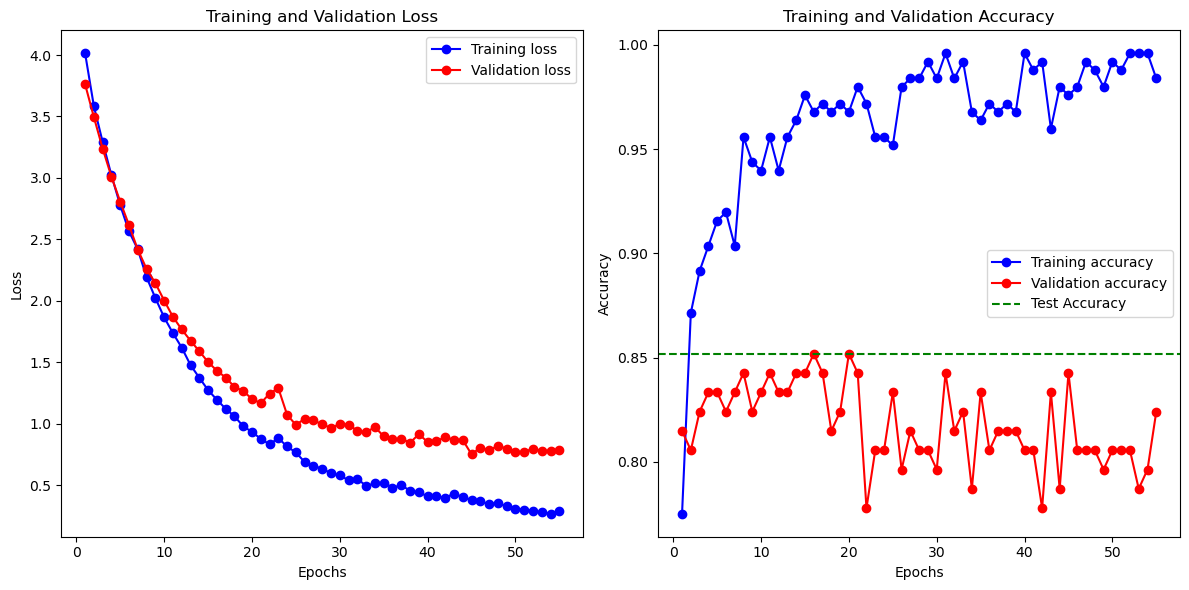

In [923]:
# Save Best Model
best_model = keras.models.load_model('best_model.keras')

# Test data evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f'Test Accuracy of the Best Model: {test_accuracy:.4f}')

# Assesment scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# plotting
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## cpg0012 Validation with Deep Learning Model

In [924]:
# Best Model
y_pred = model.predict(x_val_df)
np.where(y_pred != 1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


(array([  8,  11,  18,  29,  36,  48,  55,  56,  60,  65,  77,  80,  83,
         90,  92,  95,  98,  99, 110, 124, 127, 134, 136, 145, 152, 156,
        157, 161, 185, 192, 193, 196, 204, 214, 229, 230, 240, 245, 250,
        260, 285, 293, 297, 301, 307, 318], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

In [978]:
# Find Near Data
from sklearn.neighbors import NearestNeighbors

# Choose specific data
specific_data = x_val_df.iloc[[92], :] # 92

# NearestNeighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(x_val_df)
distances, indices = nbrs.kneighbors(specific_data)

closet_data = x_val_df.iloc[indices[0]]


print(f'Selected Data Index: {specific_data.index[0]}')
print(f'Closest 5 Data Indices: {closet_data.index.tolist()}')

for idx in closet_data.index.tolist():
    value = x_val_meta.loc[idx, 'Metadata_broad_sample']
    print(value) # plate 306

Selected Data Index: 92
Closest 5 Data Indices: [92, 134, 260, 185, 11]
BRD-K04010869-001-02-6
BRD-K06426971-001-01-9
BRD-K12219985-001-04-8
BRD-K08998509-001-01-6
BRD-A98888138-001-02-9
